In [1]:
import deeplake

from PIL import Image
from tqdm import tqdm
import numpy as np
import os
import time
import pandas as pd
import warnings

from torchvision import datasets, transforms, models
warnings.filterwarnings(action='ignore')

/home/bdai/anaconda3/envs/deep_lake/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.6.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
def timing(start):
    print(f'Elapsed time: {time.time() - start:.2f} s')
# start = time.time()

# 1. Load Dataset

In [3]:
start = time.time()

save_path = "/home/bdai/deeplake_work"
data = deeplake.load(save_path + "/deeplake_train")
train_data, val_data = data.random_split([0.8, 0.2])
test_data = deeplake.load(save_path + "/deeplake_test")

timing(start)

/home/bdai/deeplake_work/deeplake_train loaded successfully.



/home/bdai/deeplake_work/deeplake_test loaded successfully.

Elapsed time: 7.05 s


# 2. Image preprocessing

In [4]:
NUM_EPOCHS = 2
BATCH_SIZE = 64

image_shape = (3, 224, 224)

## 1) Preprocess images

In [24]:
transformers = [transforms.ToPILImage(),
               transforms.Lambda(lambda image: image.resize([image_shape[1],image_shape[2]]).convert('RGB')),
               transforms.ToTensor()]
trans = transforms.Compose(transformers)

train_loader= train_data.pytorch(batch_size = BATCH_SIZE, num_workers = 0, transform = {'images': trans, 'labels': None}, shuffle = True)
val_loader = val_data.pytorch(batch_size = BATCH_SIZE, num_workers = 0, transform = {'images': trans, 'labels': None}, shuffle = True)
test_loader = test_data.pytorch(batch_size = BATCH_SIZE, num_workers = 0, transform = {'images': trans, 'labels': None}, shuffle = False)

In [37]:
def transform(sample_in):
    start = time.time()
    transformed_image = trans(sample_in['images'])
    end = time.time()
    transform_time = end - start
    return {'images': transformed_image, 'labels': sample_in['labels'], 'time': transform_time}

#PyTorch Dataloader
train_loader= train_data.pytorch(batch_size = BATCH_SIZE, num_workers = 0, transform = transform, tensors = ['images', 'labels'], shuffle = True)

## 2) Examining execution time for dataloading and transorming a batch    

In [6]:
start = time.time()

for batch in tqdm(train_loader):
    input, label = batch['images'], batch['labels']
timing(start)

100%|█████████████████████████████████████████| 375/375 [05:11<00:00,  1.20it/s]

Elapsed time: 311.87 s


In [31]:
train_data.images[:10]

Tensor(key='images', index=Index([(11796, 11793, 11792, 11790, 11795, 11791, 11794, 11789, 4332, 4347)]))

In [44]:
total_time = 0
total_trans_time = 0
time_start = time.time()
for batch in tqdm(train_loader):
    input, label, trans_time = batch['images'], batch['labels'], batch['time']
    time_end = time.time()
    cur_time = time_end - time_start
    total_time += cur_time
    total_trans_time += trans_time.sum().item()
    time_start = time.time()

100%|█████████████████████████████████████████| 375/375 [04:41<00:00,  1.33it/s]


In [48]:
total_trans_time / total_time
total_time

281.9712600708008

torch.Size([64, 3, 224, 224])

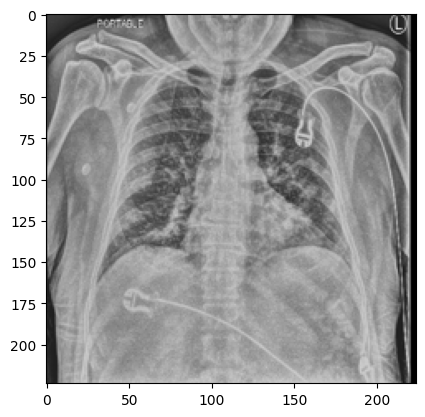

In [12]:
import matplotlib.pyplot as plt

idx = 3
plt.imshow(batch["images"][idx].permute(1, 2, 0))
batch["images"].shape

# 3. Train Model

In [13]:
import numpy as np
import torch
import torchvision

## 1) Get the model ResNet from torchvision

In [14]:
def get_model(lr=0.001):
    # Load a ResNet50 model from torchvision
    model = torchvision.models.resnet50(pretrained=True)
    # Freeze parameters in the feature extraction layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Add a new classifier layer for transfer learning
    num_ftrs = model.fc.in_features
    # Parameters of newly constructed modules have requires_grad=True by default
    model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, 1), torch.nn.Sigmoid())
    
    
    
    return model

## 2) Define the train and evaluate function for the model

In [18]:
def train_one_epoch(model, criterion, optimizer, scheduler, 
                    train_loader, steps_per_epoch, epoch, 
                    device):
    
    # statistics
    running_loss = 0.0
    running_corrects = 0
    total_loading = 0
    total_training = 0 
    total_stats = 0
    
    start = time.time()
    model.train()  # Set model to training mode
    # Iterate over the data for one epoch.
    load_start = time.time()
    for data in tqdm(train_loader):
        inputs, labels = data['images'].to(device), data['labels'].to(device)
        labels = labels.float()
        load_end = time.time()
        current_load_time = load_end-load_start
        total_loading += current_load_time
        # Track history in training
        train_start = time.time()
    
        # Track history in training
        with torch.set_grad_enabled(True):
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            preds = outputs > 0.5
            
            loss = criterion(outputs, labels)
            
            # backward + optimize
            loss.backward()
            optimizer.step()
        train_end = time.time()
        current_train_time = train_end-train_start
        total_training += current_train_time
        # stats_start = time.time()
        # # statistics
        # running_loss += loss.item()
        # running_corrects += torch.sum(preds == labels.data)

        # stats_end = time.time()
        # current_stats_time = stats_end - stats_start
        # total_stats += current_stats_time
        load_start = time.time()


    scheduler.step()
    end = time.time()
    total_time = end-start
    print("Total time per epoch : {:.2f} / Dataloading time : {:.2f}  / Training time : {:.2f}"\
          .format(total_time, total_loading, total_training)) 
    # epoch_loss = running_loss / (steps_per_epoch * BATCH_SIZE)
    # epoch_acc = running_corrects.double() / (steps_per_epoch * BATCH_SIZE)

    # print("Total time per epoch : {:.2f} / Dataloading time : {:.2f}  / Training time : {:.2f} / Writing stats : {:.2f}"\
    #       .format(total_time, total_loading, total_training, total_stats))
    # print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    # return epoch_loss, epoch_acc

def evaluate(model, criterion, val_loader, validation_steps, device, 
             metric_agg_fn=None):
    model.eval()  # Set model to evaluate mode
    
    # statistics
    running_loss = 0.0
    running_corrects = 0
    
    # Iterate over all the validation data.
    for data in val_loader:
        inputs, labels = data['images'].to(device), data['labels'].to(device)
        labels = labels.float()
    
        # Do not track history in evaluation to save memory
        with torch.set_grad_enabled(False):
            # forward
            outputs = model(inputs)
            preds = outputs > 0.5
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    # The losses are averaged across observations for each minibatch.
    epoch_loss = running_loss / validation_steps
    epoch_acc = running_corrects.double() / (validation_steps * BATCH_SIZE)
    
    # metric_agg_fn is used in the distributed training to aggregate the metrics on all workers
    if metric_agg_fn is not None:
        epoch_loss = metric_agg_fn(epoch_loss, 'avg_loss')
        epoch_acc = metric_agg_fn(epoch_acc, 'avg_acc')
    
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## 3) Train and evaluate the model on the local machine

In [19]:
def train_and_evaluate(lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    
    model = get_model(lr=lr)
    model = model.to(device)
    
    criterion = torch.nn.BCELoss()
    
    # Only parameters of final layer are being optimized.
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
    
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    
    steps_per_epoch = len(train_loader)
    
    validation_steps = len(val_loader)
    
    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        print('-' * 10)
        
        train_loss, train_acc = train_one_epoch(model, criterion, optimizer, exp_lr_scheduler, 
                                              train_loader, steps_per_epoch, epoch, 
                                              device)
        val_loss, val_acc = evaluate(model, criterion, val_loader, validation_steps, device)
    return val_loss

In [20]:
start = time.time()

loss = train_and_evaluate(2e-2)

timing(start)

cuda
Epoch 1/2
----------


100%|█████████████████████████████████████████| 375/375 [04:51<00:00,  1.29it/s]

Total time per epoch : 291.78 / Dataloading time : 289.27  / Training time : 2.51


NameError: name 'epoch_loss' is not defined

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lr = 2e-2
model = get_model(lr=lr)
model = model.to(device)

criterion = torch.nn.BCELoss()

# Only parameters of final layer are being optimized.
optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


steps_per_epoch = len(train_loader)

validation_steps = len(val_loader)

model.train()  # Set model to training mode

# statistics
running_loss = 0.0
running_corrects = 0
idx = 0
# Iterate over the data for one epoch.
for data in tqdm(train_loader):
    inputs, labels = data['images'].to(device), data['labels'].to(device)
    labels = labels.float()

    # Track history in training
    with torch.set_grad_enabled(True):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        outputs = model(inputs)
        preds = outputs > 0.5
        
        loss = criterion(outputs, labels)
        print(loss)
        
        # backward + optimize
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    idx += 1
    if idx == 100:
        break
scheduler.step()

epoch_loss = running_loss / (steps_per_epoch * BATCH_SIZE)
epoch_acc = running_corrects.double() / (steps_per_epoch * BATCH_SIZE)

print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

cuda


  0%|                                           | 1/375 [00:00<05:32,  1.13it/s]

tensor(0.6814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  1%|▏                                          | 2/375 [00:02<07:18,  1.18s/it]

tensor(0.6417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  1%|▎                                          | 3/375 [00:03<06:36,  1.07s/it]

tensor(0.5546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  1%|▍                                          | 4/375 [00:04<06:38,  1.07s/it]

tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  1%|▌                                          | 5/375 [00:05<06:02,  1.02it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  2%|▋                                          | 6/375 [00:05<05:51,  1.05it/s]

tensor(0.4012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  2%|▊                                          | 7/375 [00:07<06:07,  1.00it/s]

tensor(0.4235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  2%|▉                                          | 8/375 [00:08<05:56,  1.03it/s]

tensor(0.4335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  2%|█                                          | 9/375 [00:09<06:10,  1.01s/it]

tensor(0.3528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█                                         | 10/375 [00:10<06:00,  1.01it/s]

tensor(0.3291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█▏                                        | 11/375 [00:11<06:14,  1.03s/it]

tensor(0.3838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█▎                                        | 12/375 [00:12<06:12,  1.03s/it]

tensor(0.2890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█▍                                        | 13/375 [00:13<06:06,  1.01s/it]

tensor(0.5968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  4%|█▌                                        | 14/375 [00:14<06:04,  1.01s/it]

tensor(0.1811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  4%|█▋                                        | 15/375 [00:15<06:23,  1.07s/it]

tensor(0.2594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  4%|█▊                                        | 16/375 [00:16<06:07,  1.02s/it]

tensor(0.4019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  5%|█▉                                        | 17/375 [00:17<06:11,  1.04s/it]

tensor(0.4464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  5%|██                                        | 18/375 [00:18<05:55,  1.00it/s]

tensor(0.1516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  5%|██▏                                       | 19/375 [00:19<05:57,  1.00s/it]

tensor(0.3439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  5%|██▏                                       | 20/375 [00:20<05:46,  1.02it/s]

tensor(0.3642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  6%|██▎                                       | 21/375 [00:21<06:02,  1.02s/it]

tensor(0.3953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  6%|██▍                                       | 22/375 [00:22<06:17,  1.07s/it]

tensor(0.3421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  6%|██▌                                       | 23/375 [00:23<06:10,  1.05s/it]

tensor(0.3694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  6%|██▋                                       | 24/375 [00:24<05:55,  1.01s/it]

tensor(0.3270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  7%|██▊                                       | 25/375 [00:25<06:12,  1.07s/it]

tensor(0.3110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  7%|██▉                                       | 26/375 [00:26<06:01,  1.04s/it]

tensor(0.3465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  7%|███                                       | 27/375 [00:27<05:37,  1.03it/s]

tensor(0.3037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  7%|███▏                                      | 28/375 [00:28<06:11,  1.07s/it]

tensor(0.3585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  8%|███▏                                      | 29/375 [00:29<06:05,  1.06s/it]

tensor(0.4108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  8%|███▎                                      | 30/375 [00:30<06:00,  1.05s/it]

tensor(0.3121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  8%|███▍                                      | 31/375 [00:31<05:49,  1.02s/it]

tensor(0.1578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▌                                      | 32/375 [00:32<06:11,  1.08s/it]

tensor(0.4456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▋                                      | 33/375 [00:34<06:09,  1.08s/it]

tensor(0.2003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▊                                      | 34/375 [00:35<05:58,  1.05s/it]

tensor(0.2366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▉                                      | 35/375 [00:36<05:59,  1.06s/it]

tensor(0.2358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 10%|████                                      | 36/375 [00:36<05:43,  1.01s/it]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 10%|████▏                                     | 37/375 [00:37<05:35,  1.01it/s]

tensor(0.3501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 10%|████▎                                     | 38/375 [00:38<05:40,  1.01s/it]

tensor(0.2055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 10%|████▎                                     | 39/375 [00:39<05:40,  1.01s/it]

tensor(0.2127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▍                                     | 40/375 [00:40<05:37,  1.01s/it]

tensor(0.6099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▌                                     | 41/375 [00:41<05:15,  1.06it/s]

tensor(0.2628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▋                                     | 42/375 [00:42<05:02,  1.10it/s]

tensor(0.3292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▊                                     | 43/375 [00:43<05:47,  1.05s/it]

tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 12%|████▉                                     | 44/375 [00:44<05:27,  1.01it/s]

tensor(0.2398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 12%|█████                                     | 45/375 [00:45<05:32,  1.01s/it]

tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 12%|█████▏                                    | 46/375 [00:47<05:56,  1.08s/it]

tensor(0.3005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▎                                    | 47/375 [00:48<05:38,  1.03s/it]

tensor(0.2433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▍                                    | 48/375 [00:49<06:00,  1.10s/it]

tensor(0.4047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▍                                    | 49/375 [00:50<06:18,  1.16s/it]

tensor(0.3154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▌                                    | 50/375 [00:51<06:02,  1.11s/it]

tensor(0.3930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 14%|█████▋                                    | 51/375 [00:52<05:39,  1.05s/it]

tensor(0.1479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 14%|█████▊                                    | 52/375 [00:53<05:47,  1.07s/it]

tensor(0.2535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 14%|█████▉                                    | 53/375 [00:54<05:27,  1.02s/it]

tensor(0.4868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 14%|██████                                    | 54/375 [00:55<05:19,  1.00it/s]

tensor(0.5732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▏                                   | 55/375 [00:56<05:10,  1.03it/s]

tensor(0.1154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▎                                   | 56/375 [00:57<06:00,  1.13s/it]

tensor(0.1746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▍                                   | 57/375 [00:58<05:46,  1.09s/it]

tensor(0.3184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▍                                   | 58/375 [00:59<05:29,  1.04s/it]

tensor(0.2138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 16%|██████▌                                   | 59/375 [01:00<05:20,  1.02s/it]

tensor(0.2327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 16%|██████▋                                   | 60/375 [01:01<05:26,  1.04s/it]

tensor(0.1379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 16%|██████▊                                   | 61/375 [01:02<05:11,  1.01it/s]

tensor(0.1277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 17%|██████▉                                   | 62/375 [01:03<05:17,  1.01s/it]

tensor(0.2492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 17%|███████                                   | 63/375 [01:04<04:59,  1.04it/s]

tensor(0.3608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 17%|███████▏                                  | 64/375 [01:05<05:09,  1.01it/s]

tensor(0.3001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 17%|███████▎                                  | 65/375 [01:06<04:52,  1.06it/s]

tensor(0.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 18%|███████▍                                  | 66/375 [01:07<05:03,  1.02it/s]

tensor(0.2624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 18%|███████▌                                  | 67/375 [01:08<05:19,  1.04s/it]

tensor(0.4243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 18%|███████▌                                  | 68/375 [01:09<04:58,  1.03it/s]

tensor(0.1504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 18%|███████▋                                  | 69/375 [01:10<04:58,  1.03it/s]

tensor(0.2063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 19%|███████▊                                  | 70/375 [01:11<04:44,  1.07it/s]

tensor(0.0937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 19%|███████▉                                  | 71/375 [01:12<04:53,  1.04it/s]

tensor(0.1963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 19%|████████                                  | 72/375 [01:13<05:02,  1.00it/s]

tensor(0.3011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 19%|████████▏                                 | 73/375 [01:14<04:46,  1.06it/s]

tensor(0.2679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 20%|████████▎                                 | 74/375 [01:16<05:56,  1.19s/it]

tensor(0.3078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 20%|████████▍                                 | 75/375 [01:17<05:40,  1.14s/it]

tensor(0.2166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 20%|████████▌                                 | 76/375 [01:18<05:26,  1.09s/it]

tensor(0.2502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▌                                 | 77/375 [01:19<05:36,  1.13s/it]

tensor(0.2019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▋                                 | 78/375 [01:20<05:29,  1.11s/it]

tensor(0.1857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▊                                 | 79/375 [01:21<05:35,  1.13s/it]

tensor(0.3523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▉                                 | 80/375 [01:22<05:37,  1.14s/it]

tensor(0.1635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 22%|█████████                                 | 81/375 [01:23<05:22,  1.10s/it]

tensor(0.1025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 22%|█████████▏                                | 82/375 [01:24<05:13,  1.07s/it]

tensor(0.1530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 22%|█████████▎                                | 83/375 [01:25<05:18,  1.09s/it]

tensor(0.2352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 22%|█████████▍                                | 84/375 [01:26<04:56,  1.02s/it]

tensor(0.1107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▌                                | 85/375 [01:27<04:54,  1.02s/it]

tensor(0.1760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▋                                | 86/375 [01:28<04:48,  1.00it/s]

tensor(0.1801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▋                                | 87/375 [01:29<04:26,  1.08it/s]

tensor(0.2059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▊                                | 88/375 [01:30<04:39,  1.03it/s]

tensor(0.2719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 24%|█████████▉                                | 89/375 [01:31<04:56,  1.04s/it]

tensor(0.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 24%|██████████                                | 90/375 [01:32<04:43,  1.01it/s]

tensor(0.2061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 24%|██████████▏                               | 91/375 [01:33<04:39,  1.02it/s]

tensor(0.2529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██████████▎                               | 92/375 [01:34<05:11,  1.10s/it]

tensor(0.1934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██████████▍                               | 93/375 [01:35<04:58,  1.06s/it]

tensor(0.1926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██████████▌                               | 94/375 [01:36<04:41,  1.00s/it]

tensor(0.1825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██████████▋                               | 95/375 [01:37<04:25,  1.05it/s]

tensor(0.2133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 26%|██████████▊                               | 96/375 [01:38<04:12,  1.11it/s]

tensor(0.1054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 26%|██████████▊                               | 97/375 [01:39<04:53,  1.05s/it]

tensor(0.2624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 26%|██████████▉                               | 98/375 [01:41<05:07,  1.11s/it]

tensor(0.1957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 26%|███████████                               | 99/375 [01:42<05:06,  1.11s/it]

tensor(0.2620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


 26%|███████████                               | 99/375 [01:43<04:47,  1.04s/it]

tensor(0.6178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train Loss: 0.0808 Acc: 0.2322


In [46]:
running_corrects/(64*100)

tensor(0.8708, device='cuda:0')